# Universal Bank

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem Definition](#toc1_)    
- 2. [Getting Started](#toc2_)    
  - 2.1. [Load Libraries](#toc2_1_)    
  - 2.2. [Load Dataset](#toc2_2_)    
- 3. [Exploratory Data Analysis](#toc3_)    
  - 3.1. [Descriptive Statistics](#toc3_1_)    
  - 3.2. [Data Visualisation](#toc3_2_)    
  - 3.3. [Time Series Analysis](#toc3_3_)    
- 4. [Data Preparation](#toc4_)    
  - 4.1. [Data Cleaning](#toc4_1_)    
  - 4.2. [Feature Selection](#toc4_2_)    
- 5. [Evaluate Algorithms and Models](#toc5_)    
  - 5.1. [Train/Test Split](#toc5_1_)    
  - 5.2. [Evaluation Metrics](#toc5_2_)    
  - 5.3. [Compare Models and Algorithms](#toc5_3_)    
    - 5.3.1. [Machine Learning models-scikit-learn](#toc5_3_1_)    
    - 5.3.2. [Time Series based Models-ARIMA and LSTM](#toc5_3_2_)    
- 6. [Model Tuning and Grid Search](#toc6_)    
- 7. [Finalise the model](#toc7_)    
  - 7.1. [Result on the test dataset](#toc7_1_)    
  - 7.2. [Save Model for Later Use](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Problem Definition](#toc0_)

## 2. <a id='toc2_'></a>[Getting Started](#toc0_)

In [1]:
rm(list = ls())
options(warn = -1)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,633885,33.9,1391154,74.3,1059787,56.6
Vcells,1176358,9.0,8388608,64.0,1816400,13.9


### 2.1. <a id='toc2_1_'></a>[Load Libraries](#toc0_)

In [3]:
suppressWarnings(library(conflicted))
suppressWarnings(library(tidyverse))
suppressWarnings(library(DataExplorer))
suppressWarnings(library(DMwR))
suppressWarnings(library(gridExtra))
suppressWarnings(library(GGally))
suppressWarnings(library(caret))
suppressWarnings(library(MASS))
suppressWarnings(library(readxl))
suppressWarnings(library(car))
suppressWarnings(library(rpart))
suppressWarnings(library(rattle))
suppressWarnings(library(rpart.plot))
suppressWarnings(library(RColorBrewer))
suppressWarnings(library(leaps))
suppressWarnings(library(VIM))
suppressWarnings(library(ggplot2))
suppressWarnings(library(psych))

### 2.2. <a id='toc2_2_'></a>[Load Dataset](#toc0_)

In [5]:
df <- read.csv("../_data/universal-bank.csv")

## 3. <a id='toc3_'></a>[Exploratory Data Analysis](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Descriptive Statistics](#toc0_)

In [6]:
describe(df)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ID,1,5000,2500.500000,1443.5200033,2500.5,2500.500000,1853.25000,1,5000,4999,0.00000000,-1.20072002,20.414455663
Age,2,5000,45.338400,11.4631656,45.0,45.384500,14.82600,23,67,44,-0.02932308,-1.15385296,0.162113643
Experience,3,5000,20.104600,11.4679537,20.0,20.133000,14.82600,-3,43,46,-0.02630890,-1.12235262,0.162181356
Income,4,5000,73.774200,46.0337293,64.0,68.835000,42.99540,8,224,216,0.84083387,-0.04658144,0.651015243
ZIP.Code,5,5000,93152.503000,2121.8521973,93437.0,93236.132000,1968.89280,9307,96651,87344,-12.49272197,485.52153695,30.007521548
Family,6,5000,2.396400,1.1476630,2.0,2.370500,1.48260,1,4,3,0.15512755,-1.40402134,0.016230406
CCAvg,7,5000,1.937938,1.7476590,1.5,1.645638,1.33434,0,10,10,1.59748440,2.64060373,0.024715630
Education,8,5000,1.881000,0.8398691,2.0,1.851250,1.48260,1,3,2,0.22695708,-1.54635137,0.011877542
Mortgage,9,5000,56.498800,101.7138021,0.0,32.979250,0.00000,0,635,635,2.10274009,4.74774142,1.438450384


In [7]:
tail(df)

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
4995,4995,64,40,75,94588,3,2.0,3,0,0,0,0,1,0
4996,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4997,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4998,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4999,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
5000,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


### 3.2. <a id='toc3_2_'></a>[Data Visualisation](#toc0_)

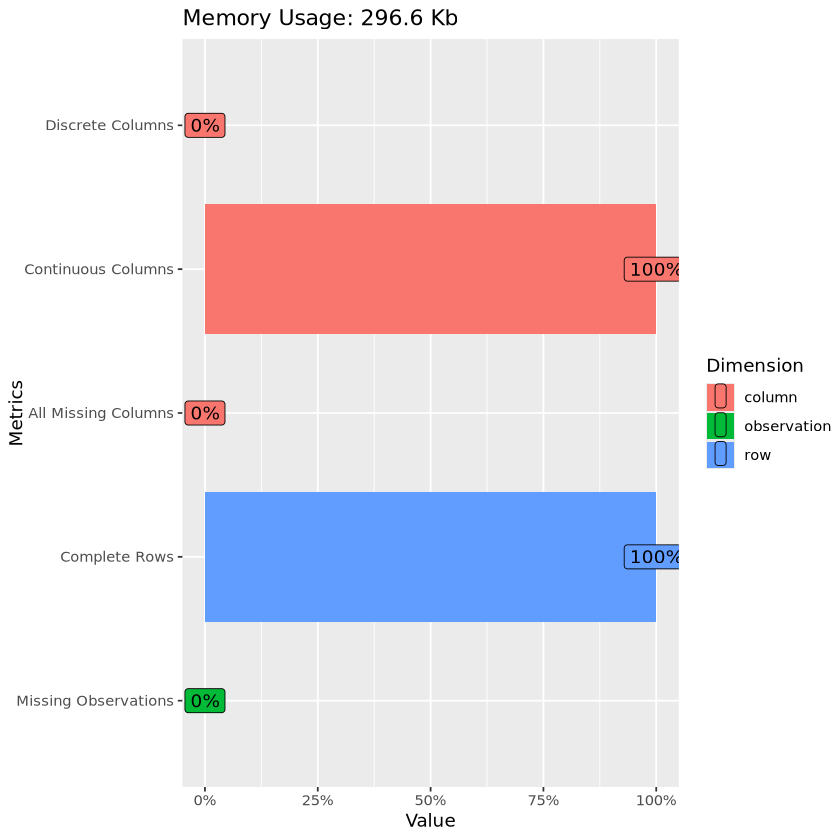

In [ ]:
DataExplorer::plot_intro(df)
DataExplorer::plot_missing(df)
#VIM::aggr(df)

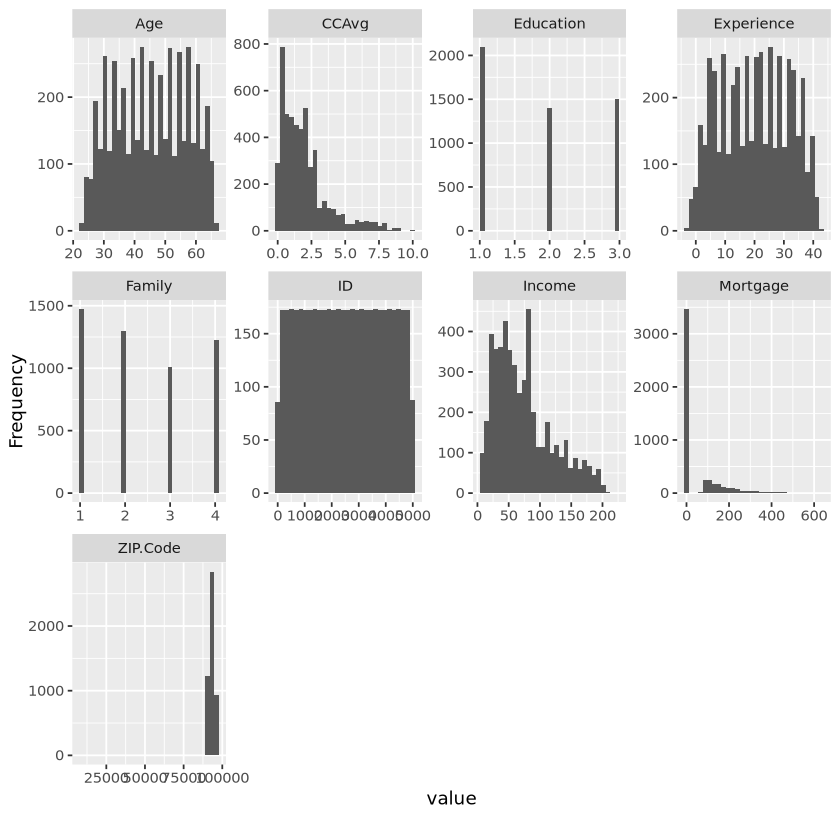

In [ ]:
plot_histogram(df)

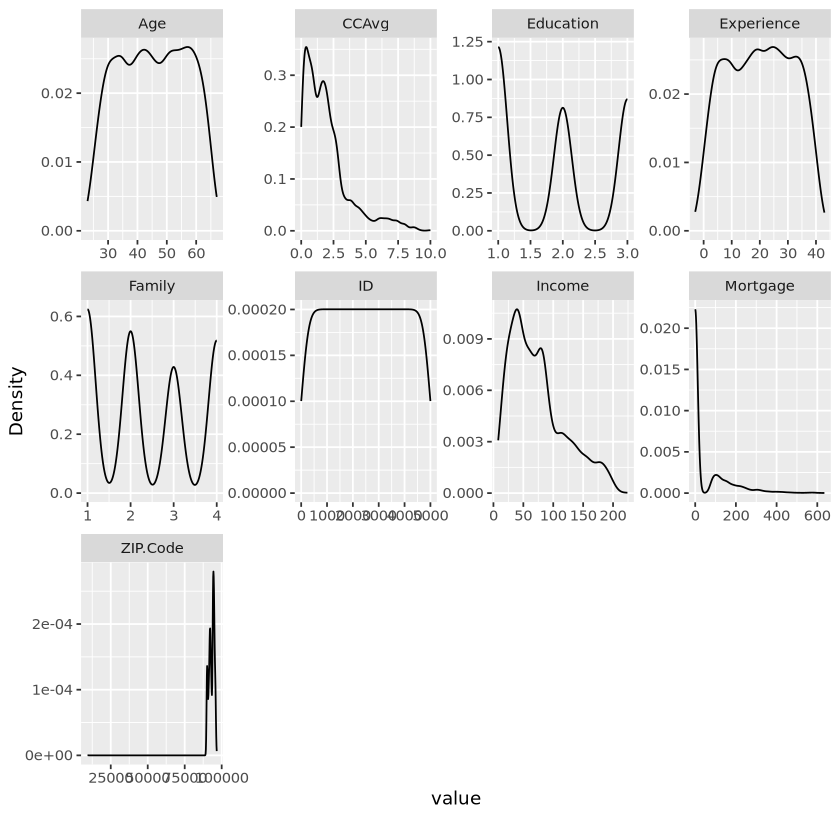

In [33]:
plot_density(df)

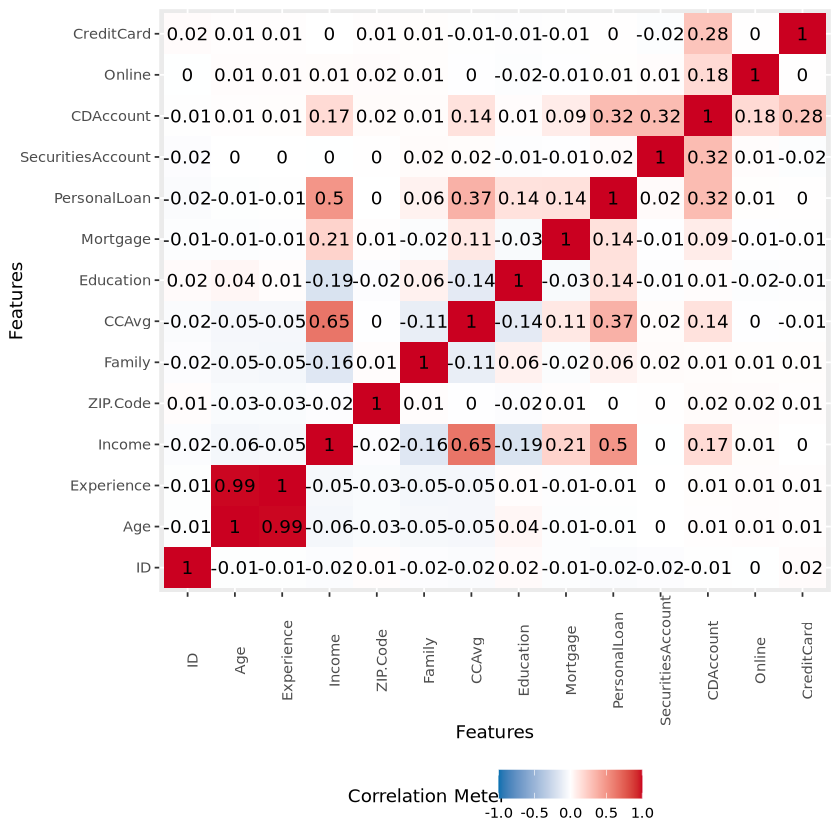

In [29]:
plot_correlation(df)

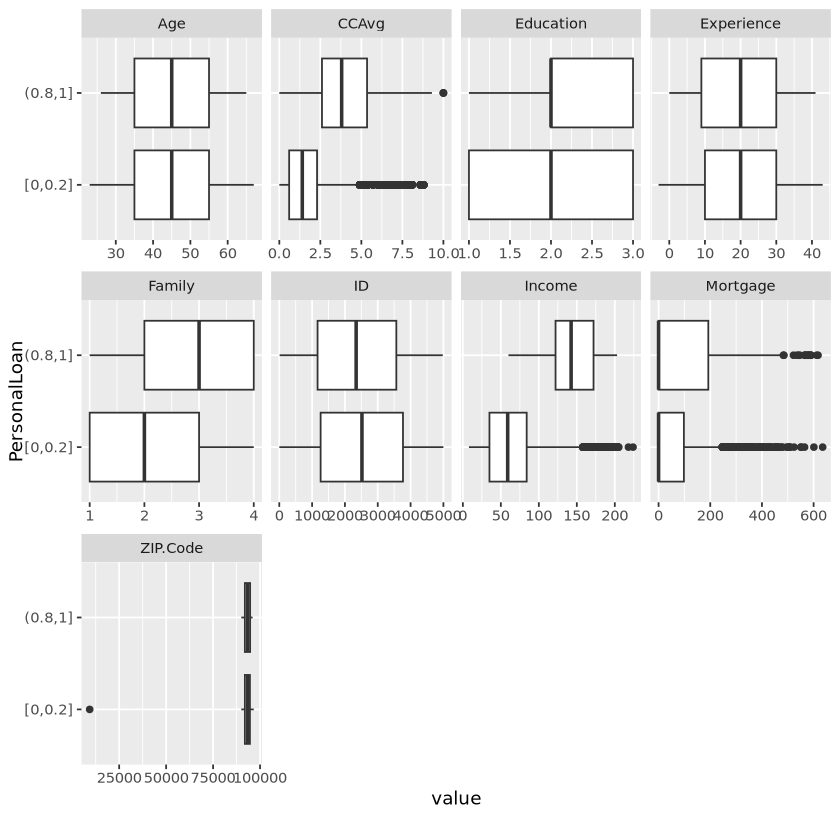

In [36]:
plot_boxplot(df, by = 'PersonalLoan')

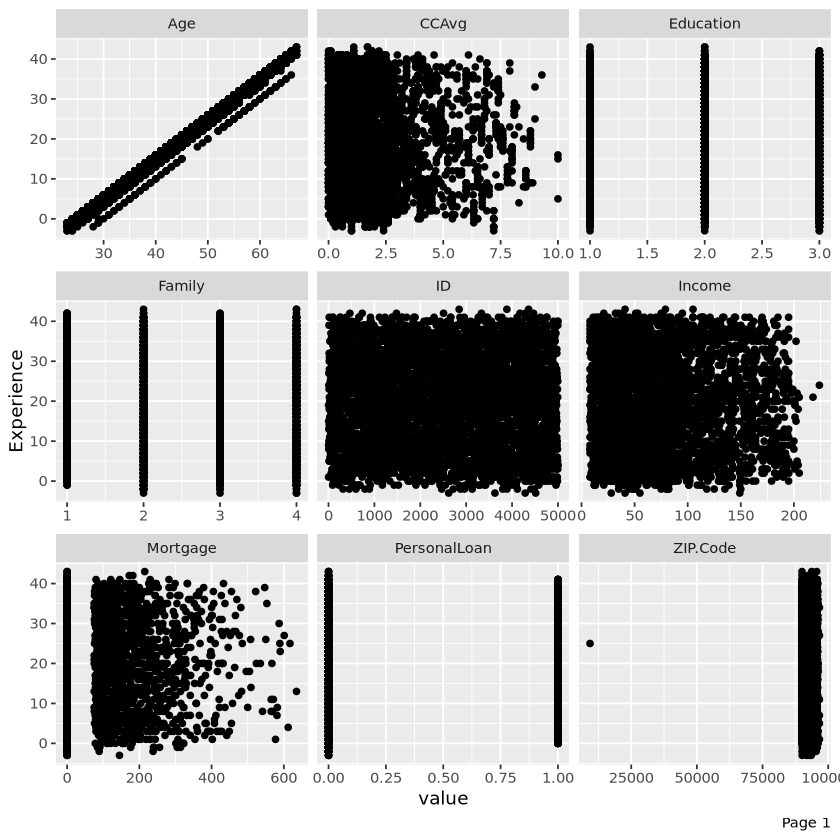

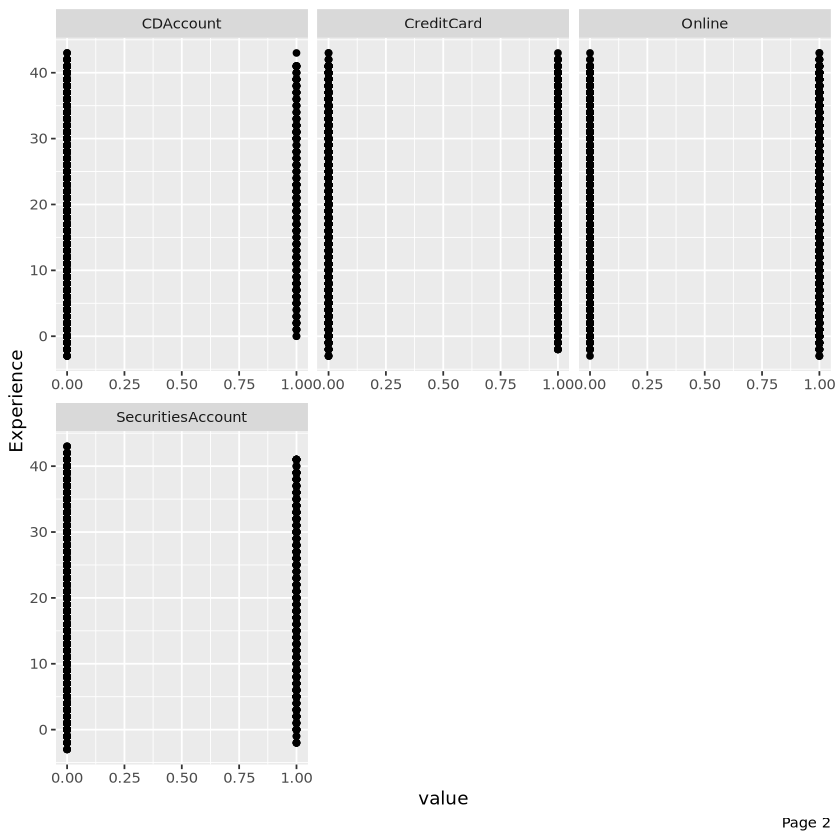

In [42]:
DataExplorer::plot_scatterplot(df, by = 'Experience')

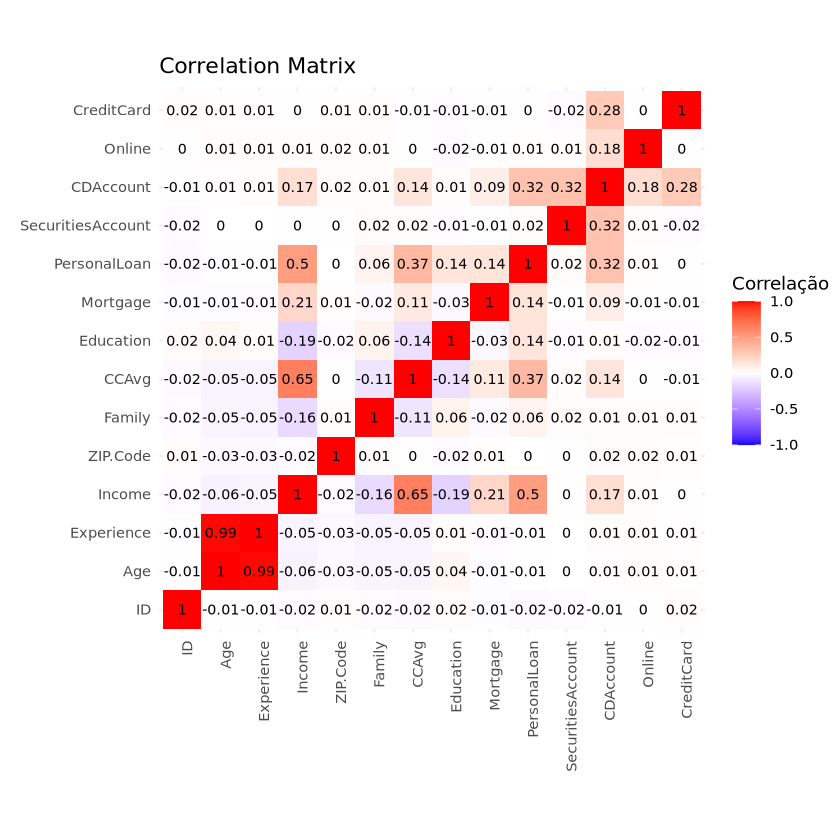

In [22]:
df_plot <- cor(df) |> 
  reshape2::melt()

# Gerar o gráfico de mapa de calor com a correlação visível nas células
ggplot(df_plot, aes(Var1, Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1, 1), name = "Correlação") + 
  geom_text(aes(label = round(value, 2)), color = "black", size = 3) + # Adiciona os valores das correlações
  labs(title = "Correlation Matrix", x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1), # Rotacionar os nomes das variáveis no eixo X
        axis.text.y = element_text(angle = 0, hjust = 1)) +
  coord_fixed() # Manter a proporção da matriz

## 4. <a id='toc4_'></a>[Data Preparation](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Data Cleaning](#toc0_)

### 4.2. <a id='toc4_2_'></a>[Feature Selection](#toc0_)

## 5. <a id='toc5_'></a>[Evaluate Algorithms and Models](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Train/Test Split](#toc0_)

### 5.2. <a id='toc5_2_'></a>[Test Options and Evaluation Metrics](#toc0_)

### 5.3. <a id='toc5_3_'></a>[Compare Models and Algorithms](#toc0_)

#### 5.3.1. <a id='toc5_3_1_'></a>[Machine Learning models-scikit-learn](#toc0_)

Regression and Tree Regression Algorithms

Neural Network Algorithms


Ensable Models

#### 5.3.2. <a id='toc5_3_2_'></a>[Time Series based Models-ARIMA and LSTM](#toc0_)

## 6. <a id='toc6_'></a>[Model Tuning and Grid Search](#toc0_)

## 7. <a id='toc7_'></a>[Finalise the model](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Result on the test dataset](#toc0_)

### 7.2. <a id='toc7_2_'></a>[Save Model for Later Use](#toc0_)